In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.interpolate import CubicSpline,interp1d,InterpolatedUnivariateSpline
import time

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.interpolate import CubicSpline

# Model parameters
gamma = 0.5
beta = 0.99
alpha = 0.40
delta = 0.019
k0 = 10.0

# Numerical parameters
k_l = 5.0
k_u = 100.0
tol = 1e-6
itermax = 2000

# Counter variables
TT = 360
grid_res = 500
verbose = False
n_err = 10000

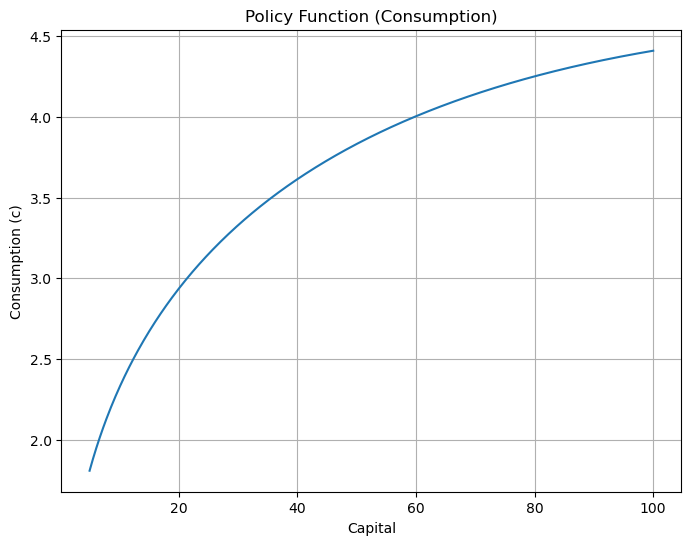

Converged after 206 iterations


In [12]:
# Create the grid for k and define policy function
grid_k = np.linspace(k_l, k_u, grid_res)

# Initialize array for consumption
c = grid_k**alpha - delta*grid_k

# Plot policy function
plt.figure(figsize=(8, 6))
plt.plot(grid_k, c)
plt.title("Policy Function (Consumption)")
plt.xlabel("Capital")
plt.ylabel("Consumption (c)")
plt.grid(True)
plt.show()

# Define the first order condition for optimal consumption
def foc(x_in, i, spline_c):
    """
    First order condition for optimal consumption
    """
    #Calc future capital
    k_plus = max((1-delta)*grid_k[i] + grid_k[i]**alpha - x_in,1e-6)

    # calc future consumption
    c_plus = spline_c(k_plus)

    foc = x_in - (beta*(1+alpha*k_plus**(alpha-1)-delta))**(-gamma)*c_plus
    return foc

# Use timer to measure convergence time
t0 = time.time()     

for it in range(itermax):
    # Interpolate consumption function for spline evaluation
    spline_c = InterpolatedUnivariateSpline(grid_k, c, k=3)

    c_new = np.zeros_like(c)

    for i in range(len(grid_k)):
        cons_min = 0
        cons_max = (1-delta)*grid_k[i] + grid_k[i]**alpha #Everything is consumed kplus = 0
        fa = foc(cons_min, i, spline_c)
        fb = foc(cons_max, i, spline_c)
    
        if fa * fb > 0:
            print(f"Warning: No root at grid_k[{i}]={grid_k[i]:.3f}: FOC at min={fa:.3e}, max={fb:.3e}, iteration={it}")
            # fallback: assign the feasible endpoint (often max or min, or previous c[i])
            c_new[i] = np.clip(c[i], cons_min, cons_max)
            continue
    
        result = root_scalar(foc, args=(i, spline_c), bracket=(cons_min, cons_max), method="brentq")
        if not result.converged:
            print(f"Root finding failed at i = {i}")
            c_new[i] = np.clip(c[i], cons_min, cons_max)
        else:
            c_new[i] = result.root

    # Convergence check for the objective function
    con_lev = np.max(np.abs(c_new - c) / np.maximum(np.abs(c), tol))
    if verbose:
        print(f"Iteration {it+1:4d}, Convergence level: {con_lev:12.8f}")

    if con_lev < tol:
        print(f"Converged after {it+1} iterations")
        break

    c = c_new.copy()
else:
    print("No convergence")



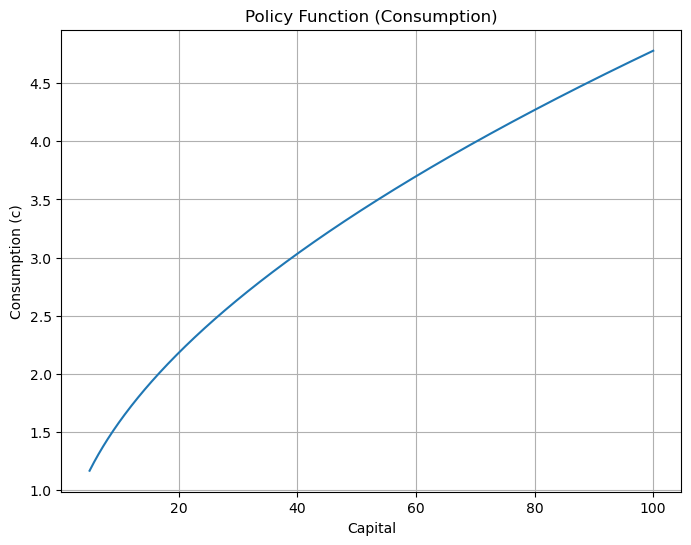

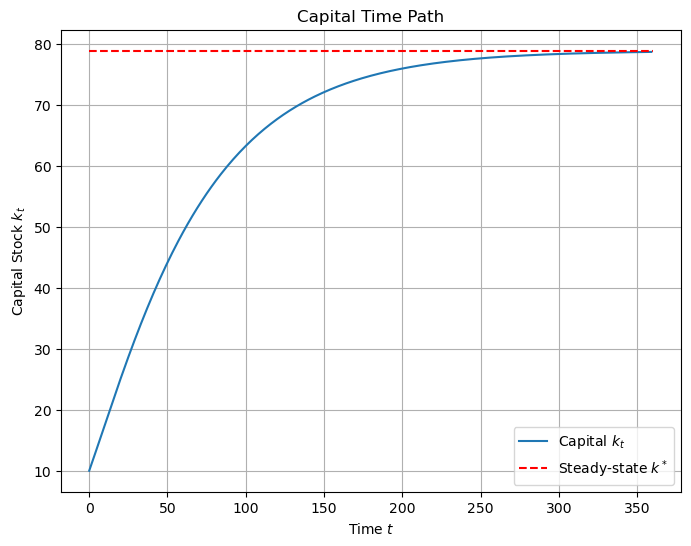

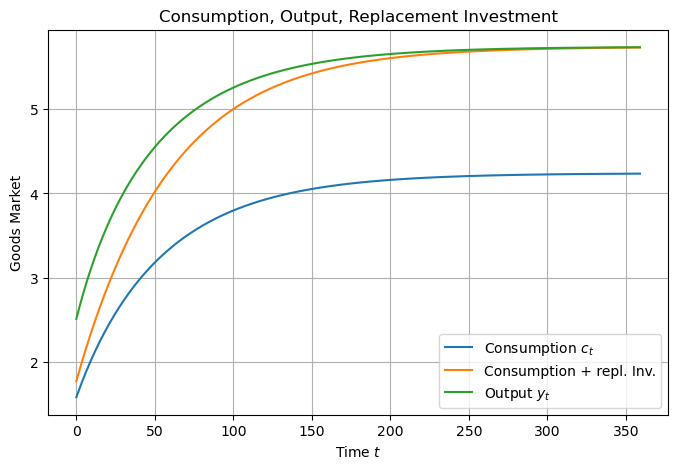

Euler equation error: 1.002065111832693e-06


In [37]:
# Calculate steady states
theta = 1.0 / beta - 1.0
k_stat = (alpha / (delta + theta)) ** (1.0 / (1.0 - alpha))
y_stat = k_stat ** alpha
c_stat = y_stat - delta * k_stat

# Calculate the time path of consumption and capital numerically
k_t = np.zeros(TT)
c_t = np.zeros(TT)
y_t = np.zeros(TT)
k_t[0] = k0
c_t[0] = spline_c(k_t[0])
y_t[0] = k_t[0]**alpha
for it in range(1,TT):
    k_t[it] = (1-delta)*k_t[it-1] + k_t[it-1]**alpha - c_t[it-1]
    c_t[it] = spline_c(k_t[it])
    y_t[it] = k_t[it]**alpha

# Plot policy function
plt.figure(figsize=(8, 6))
plt.plot(grid_k, c)
plt.title("Policy Function (Consumption)")
plt.xlabel("Capital")
plt.ylabel("Consumption (c)")
plt.grid(True)
plt.show()

# Plot time path of capital
plt.figure(figsize=(8, 6))
plt.plot(range(TT), k_t, label='Capital $k_t$')
plt.plot([0, TT], [k_stat, k_stat], 'r--', label='Steady-state $k^*$')
plt.xlabel('Time $t$')
plt.ylabel('Capital Stock $k_t$')
plt.legend()
plt.grid()
plt.title('Capital Time Path')
plt.show()

# Plot time paths for goods market
plt.figure(figsize=(8, 5))
plt.plot(range(TT), c_t, label='Consumption $c_t$')
plt.plot(range(TT), c_t + delta * k_t, label='Consumption + repl. Inv.')
plt.plot(range(TT), y_t, label='Output $y_t$')
plt.xlabel('Time $t$')
plt.ylabel('Goods Market')
plt.legend()
plt.grid()
plt.title('Consumption, Output, Replacement Investment')
plt.show()

# Calculate euler equation error
err = 0
grid = np.linspace(k_l, k_u, n_err)
c_err = np.zeros(n_err)
for i in range(n_err):
    c_err[i] = spline_c(grid[i])
splines = InterpolatedUnivariateSpline(grid, c_err, k=3)

# We need to implement the foc directly as our function does not use the communication vriable in comparison to the book
for ik in range(n_err):
    k_com = k_l + (k_u-k_l)*ik/n_err
    c_err = splines(k_com)
    # future capital
    kplus = (1-delta)*k_com + k_com**alpha - c_err
    # calculate future consumption
    cplus = splines(kplus)
    # get first order condition
    foc = c_err - (beta*(1+alpha*kplus**(alpha-1)-delta))**(-gamma)*cplus
    
    err_temp = abs(foc/c_err)
    if(err_temp > err):
        err = err_temp
print('Euler equation error:',err)
